In [1]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

dataset_path = '/Users/siriduggineni/Downloads/archive (9)/'
train_path = os.path.join(dataset_path, 'training')
test_path = os.path.join(dataset_path, 'testing')

train_images = []
train_labels = []
for folder_name in os.listdir(train_path):
    folder_path = os.path.join(train_path, folder_name)
    for image_name in os.listdir(folder_path):
        image_path = os.path.join(folder_path, image_name)
        train_images.append(image_path)
        train_labels.append(folder_name)

test_images = []
test_labels = []
for folder_name in os.listdir(test_path):
    folder_path = os.path.join(test_path, folder_name)
    for image_name in os.listdir(folder_path):
        image_path = os.path.join(folder_path, image_name)
        test_images.append(image_path)
        test_labels.append(folder_name)


all_images = train_images + test_images
all_labels = train_labels + test_labels


combined_data = list(zip(all_images, all_labels))
np.random.shuffle(combined_data)
all_images, all_labels = zip(*combined_data)

train_images, val_test_images, train_labels, val_test_labels = train_test_split(all_images, all_labels, test_size=0.2, random_state=42)
val_images, test_images, val_labels, test_labels = train_test_split(val_test_images, val_test_labels, test_size=0.5, random_state=42)


Sample images from the training set:


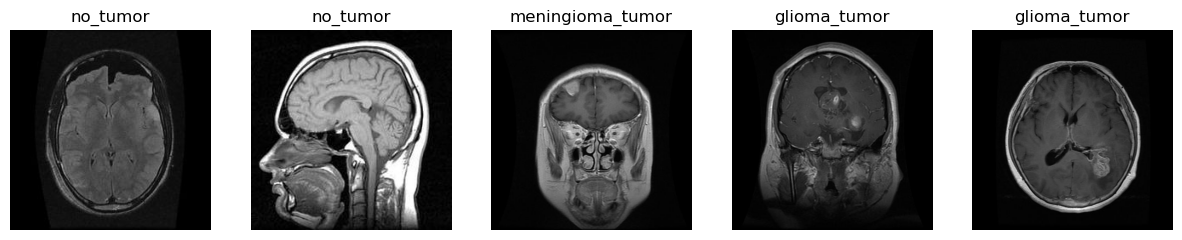

Sample images from the validation set:


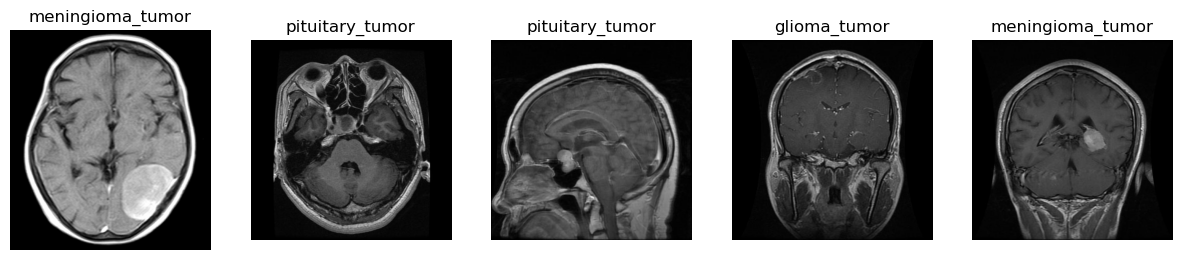

Sample images from the test set:


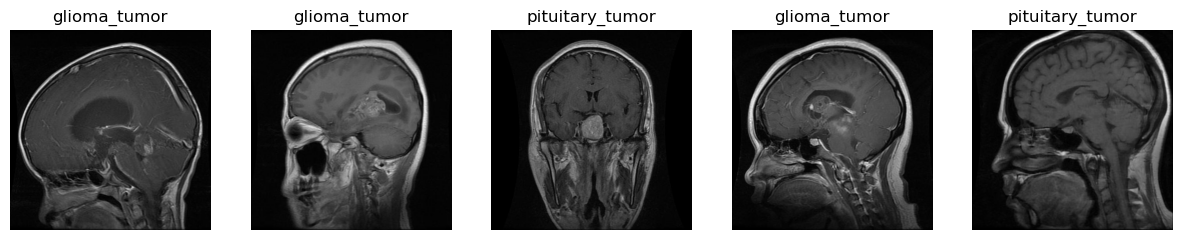

In [2]:
import cv2
import matplotlib.pyplot as plt


def display_sample_images(image_paths, labels, num_samples=5):
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))
    for i in range(num_samples):
        image = cv2.imread(image_paths[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        axes[i].imshow(image)
        axes[i].set_title(labels[i])
        axes[i].axis('off')
    plt.show()


print("Sample images from the training set:")
display_sample_images(train_images, train_labels)

print("Sample images from the validation set:")
display_sample_images(val_images, val_labels)

print("Sample images from the test set:")
display_sample_images(test_images, test_labels)


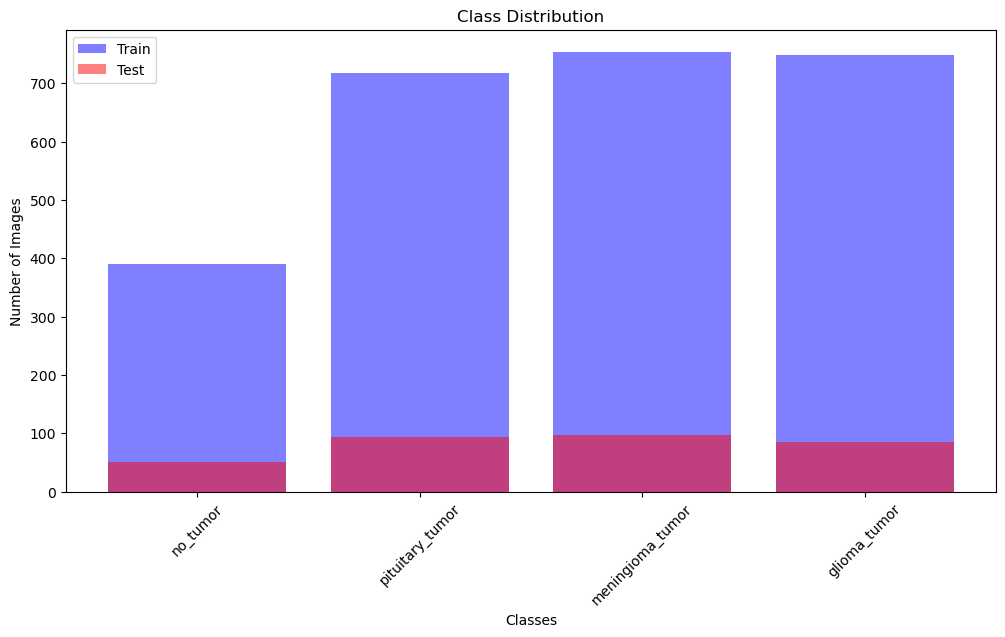

In [3]:
import matplotlib.pyplot as plt

class_counts_train = {label: train_labels.count(label) for label in set(train_labels)}
class_counts_test = {label: test_labels.count(label) for label in set(test_labels)}

plt.figure(figsize=(12, 6))
plt.bar(class_counts_train.keys(), class_counts_train.values(), alpha=0.5, color='blue', label='Train')
plt.bar(class_counts_test.keys(), class_counts_test.values(), alpha=0.5, color='red', label='Test')
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.title('Class Distribution')
plt.xticks(rotation=45)
plt.legend()
plt.show()


In [4]:
from sklearn.model_selection import train_test_split

train_images, val_test_images, train_labels, val_test_labels = train_test_split(all_images, all_labels, test_size=0.2, random_state=42)
val_images, test_images, val_labels, test_labels = train_test_split(val_test_images, val_test_labels, test_size=0.5, random_state=42)

from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)
val_labels_encoded = label_encoder.transform(val_labels)
test_labels_encoded = label_encoder.transform(test_labels)

y_train = to_categorical(train_labels_encoded)
y_val = to_categorical(val_labels_encoded)
y_test = to_categorical(test_labels_encoded)
img_width = 150
img_height = 150
def load_images(image_paths):
    images = []
    for image_path in image_paths:
        image = cv2.imread(image_path)
        image = cv2.resize(image, (img_width, img_height))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        images.append(image)
    return np.array(images)

train_images_array = load_images(train_images)
val_images_array = load_images(val_images)
test_images_array = load_images(test_images)

X_train = train_images_array / 255.0
X_val = val_images_array / 255.0
X_test = test_images_array / 255.0


In [6]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Resizing
from tensorflow.keras.models import Model
input_shape = (img_width, img_height, 3)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
import tensorflow as tf
from tensorflow.keras.applications import VGG16

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

base_model.trainable = False

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 dense_2 (Dense)             (None, 4096)              33558528  
                                                                 
 dense_3 (Dense)             (None, 4096)              16781312  
                                                                 
 dense_4 (Dense)             (None, 4)                 16388     
                                                                 
Total params: 65070916 (248.23 MB)
Trainable params: 50356228 (192.09 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [7]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
batch_size = 64
checkpoint = ModelCheckpoint('DL_best_model_vgg_pretrained.h5', monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', restore_best_weights=True)
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=batch_size,
    validation_data=(X_val, y_val),
    callbacks=[checkpoint]
)

test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("Test Accuracy:", test_accuracy)


Epoch 1/20
41/41 [==============================] - ETA: 0s - loss: 2.3838 - accuracy: 0.5642
Epoch 1: val_accuracy improved from -inf to 0.75153, saving model to DL_best_model_vgg_pretrained.h5


/Applications/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


41/41 [==============================] - 119s 3s/step - loss: 2.3838 - accuracy: 0.5642 - val_loss: 0.6358 - val_accuracy: 0.7515
Epoch 2/20
41/41 [==============================] - ETA: 0s - loss: 0.4598 - accuracy: 0.8123
Epoch 2: val_accuracy improved from 0.75153 to 0.77301, saving model to DL_best_model_vgg_pretrained.h5
41/41 [==============================] - 114s 3s/step - loss: 0.4598 - accuracy: 0.8123 - val_loss: 0.6000 - val_accuracy: 0.7730
Epoch 3/20
41/41 [==============================] - ETA: 0s - loss: 0.3033 - accuracy: 0.8908
Epoch 3: val_accuracy improved from 0.77301 to 0.86503, saving model to DL_best_model_vgg_pretrained.h5
41/41 [==============================] - 106s 3s/step - loss: 0.3033 - accuracy: 0.8908 - val_loss: 0.4034 - val_accuracy: 0.8650
Epoch 4/20
41/41 [==============================] - ETA: 0s - loss: 0.2035 - accuracy: 0.9314
Epoch 4: val_accuracy improved from 0.86503 to 0.88344, saving model to DL_best_model_vgg_pretrained.h5
41/41 [=========

In [21]:
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=batch_size,
    validation_data=(X_val, y_val),
    callbacks=[checkpoint]
)

test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("Test Accuracy:", test_accuracy)


Epoch 1/20
41/41 [==============================] - ETA: 0s - loss: 0.7286 - accuracy: 0.8139
Epoch 1: val_accuracy did not improve from 0.75767
41/41 [==============================] - 400s 10s/step - loss: 0.7286 - accuracy: 0.8139 - val_loss: 2.5072 - val_accuracy: 0.4571
Epoch 2/20
41/41 [==============================] - ETA: 0s - loss: 0.6643 - accuracy: 0.8441
Epoch 2: val_accuracy did not improve from 0.75767
41/41 [==============================] - 397s 10s/step - loss: 0.6643 - accuracy: 0.8441 - val_loss: 1.9697 - val_accuracy: 0.5859
Epoch 3/20
41/41 [==============================] - ETA: 0s - loss: 0.6323 - accuracy: 0.8499
Epoch 3: val_accuracy improved from 0.75767 to 0.76994, saving model to DL_best_model_vgg.h5
41/41 [==============================] - 398s 10s/step - loss: 0.6323 - accuracy: 0.8499 - val_loss: 0.8629 - val_accuracy: 0.7699
Epoch 4/20
41/41 [==============================] - ETA: 0s - loss: 0.5580 - accuracy: 0.8797
Epoch 4: val_accuracy improved from 

In [8]:
from tensorflow.keras.models import load_model
model = load_model('DL_best_model_vgg_pretrained.h5')

test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("Test Accuracy:", test_accuracy)


11/11 [==============================] - 12s 1s/step - loss: 0.2949 - accuracy: 0.9327
Test Accuracy: 0.932721734046936


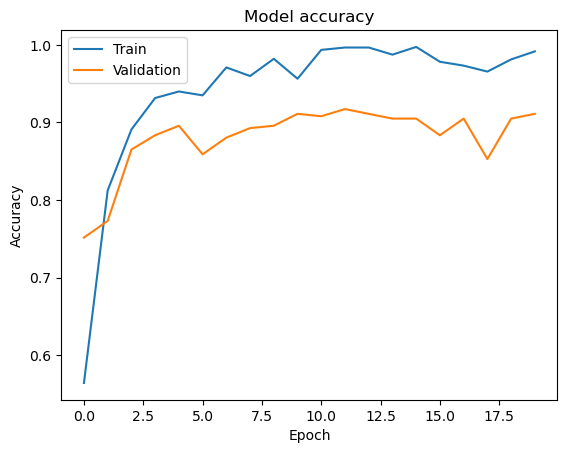

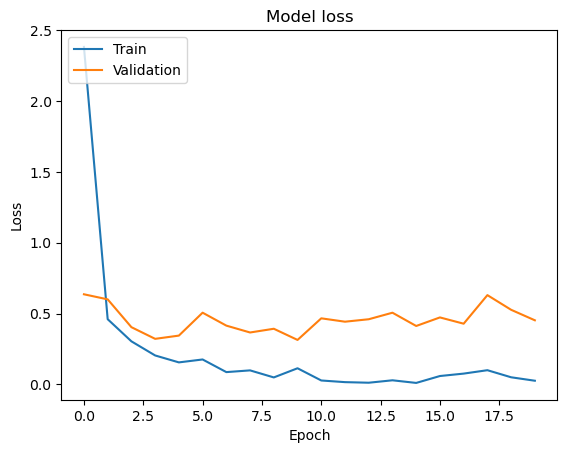

In [9]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [10]:
from sklearn.metrics import classification_report

test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

predicted_probabilities = model.predict(X_test)
predicted_classes = np.argmax(predicted_probabilities, axis=1)

predicted_labels = label_encoder.inverse_transform(predicted_classes)
true_labels = label_encoder.inverse_transform(np.argmax(y_test, axis=1))

report = classification_report(true_labels, predicted_labels)
print(report)


11/11 [==============================] - 12s 1s/step - loss: 0.2949 - accuracy: 0.9327
Test Loss: 0.2948886752128601
Test Accuracy: 0.932721734046936
11/11 [==============================] - 12s 1s/step
                  precision    recall  f1-score   support

    glioma_tumor       0.93      0.84      0.88        85
meningioma_tumor       0.87      0.96      0.91        98
        no_tumor       0.96      0.96      0.96        51
 pituitary_tumor       0.99      0.98      0.98        93

        accuracy                           0.93       327
       macro avg       0.94      0.93      0.93       327
    weighted avg       0.93      0.93      0.93       327



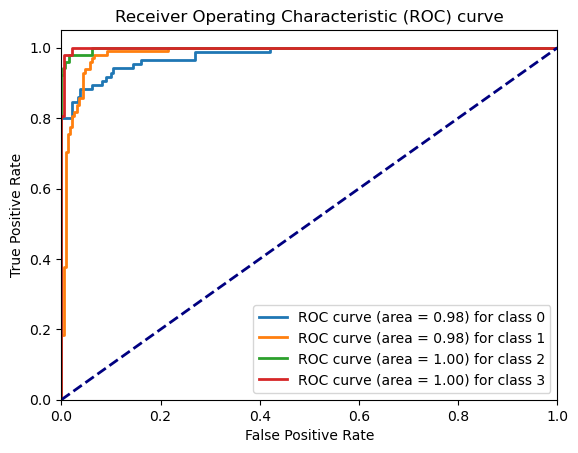

In [11]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

n_classes = len(np.unique(true_labels))
binarized_true_labels = label_binarize(true_labels, classes=np.unique(true_labels))

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(binarized_true_labels[:, i], predicted_probabilities[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(binarized_true_labels.ravel(), predicted_probabilities.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
lw = 2
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=lw, label='ROC curve (area = %0.2f) for class %s' % (roc_auc[i], i))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) curve')
plt.legend(loc="lower right")
plt.show()


1/1 [==============================] - 0s 266ms/step


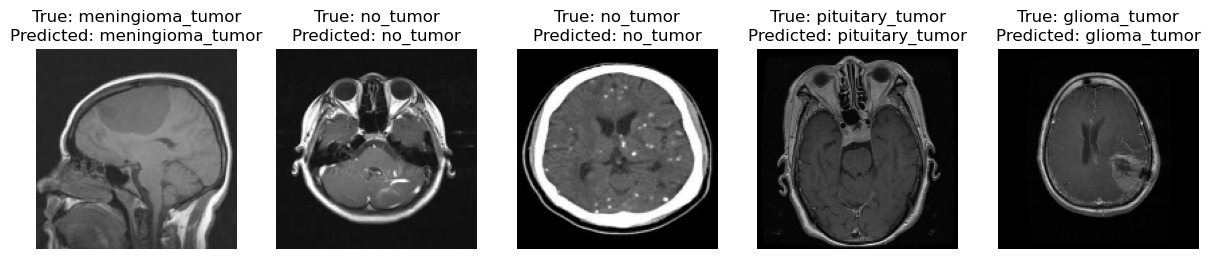

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
from tensorflow.keras.models import Model
import tensorflow as tf

sample_indices = np.random.choice(len(X_test), 5, replace=False)
sample_images = X_test[sample_indices]
sample_labels = true_labels[sample_indices]

sample_predicted_probabilities = model.predict(sample_images)
sample_predicted_labels = label_encoder.inverse_transform(np.argmax(sample_predicted_probabilities, axis=1))

plt.figure(figsize=(15, 10))
for i, (image, true_label, predicted_label) in enumerate(zip(sample_images, sample_labels, sample_predicted_labels)):
    plt.subplot(2, 5, i + 1)
    plt.imshow(image)
    plt.title(f"True: {true_label}\nPredicted: {predicted_label}")
    plt.axis('off')
plt.show()


11/11 [==============================] - 12s 1s/step


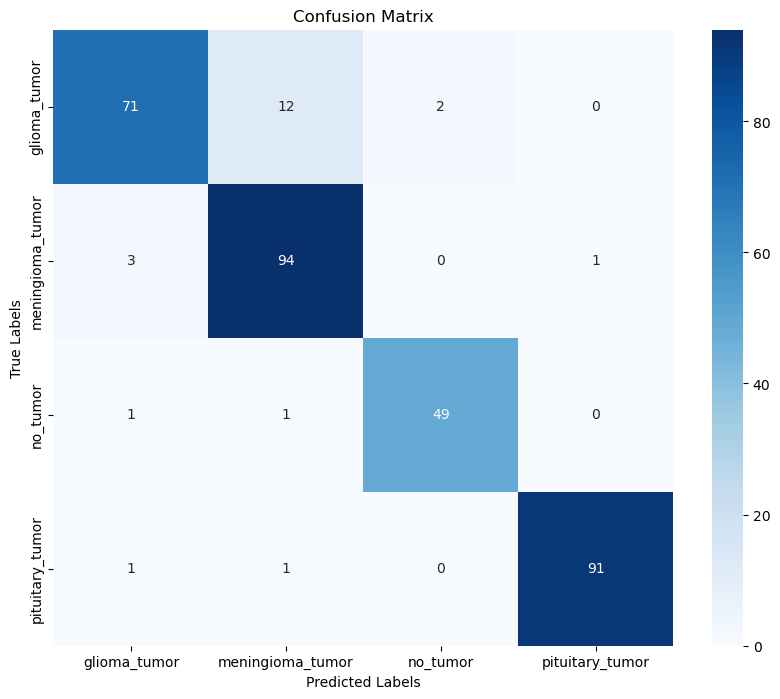

In [13]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

predicted_probabilities = model.predict(X_test)
class_names = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
predicted_labels = np.argmax(predicted_probabilities, axis=1)

true_labels = np.argmax(y_test, axis=1)

cm = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
